In [1]:
import h5py
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

## Loading functions

In [2]:
probe_tags= {'kg': 'weak lensing', 'dg': 'galaxy clustering', 'ia': 'intrinsic alignment'}

In [3]:
def smooth(m, sig_arcmin=8, nest=False):
    if sig_arcmin>0:
        m = hp.smoothing(m, sigma=np.deg2rad(sig_arcmin/60), nest=nest)    
    return m

In [4]:
def load_projected_maps(dirname, tag='nobaryons', sig_smooth_arcmin=5, verb=False):

    all_samples = []
    maps = {}
    with h5py.File(f'{dirname}/projected_probes_maps_{tag}512.h5', 'r') as f:
        probes = list(f.keys())
        for probe in probes:
            maps[probe] = {}
            probe_tag = probe_tags[probe]
            samples = f[probe].keys()
            all_samples.extend(samples)
            for sample in samples:
                
                if verb:
                    print(f'probe = {probe_tag:<25s}  sample = {sample:>10s}')
                
                maps[probe][sample] = smooth(np.array(f[probe][sample]), sig_arcmin=sig_smooth_arcmin)

                # hp.write_map(f'map_{probe}_{sample}.fits', maps[probe][sample], fits_IDL=False)
                    
    return maps, probes, list(set(all_samples))[::-1].sort()

In [5]:
def get_bin_map(id_zbin, perm_index, with_baryons=True, smooth_arcmin=0):
    baryon_effect = 'baryonified' if with_baryons else 'nobaryons'
    file_path = f'/home/tersenov/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_{perm_index:04d}/projected_probes_maps_{baryon_effect}512.h5'
    with h5py.File(file_path, 'r') as f:
        kg = np.array(f[f'kg/stage3_lensing{id_zbin+1}'])

    # # Smoothing the kg map
    if smooth_arcmin > 0:
        kg = smooth(kg, smooth_arcmin)
            
    return kg

In [6]:
def plot_map(m, title=''):

    nx, ny = 1, 1; figsize=8; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
    vmin, vmax = np.percentile(m, [5, 95])
    m_ = smooth(m)
    hp.orthview(m_, cmap='plasma', bgcolor='white', hold=True, title=title, half_sky=True, min=vmin, max=vmax)


def plot_probe_map(probe, sample, maps, tag=''):

    if probe in maps.keys():
        if sample in maps[probe].keys():
            plot_map(maps[probe][sample], title=f'{tag} {probe_tags[probe]} {sample}')
        else:
            nx, ny = 1, 1; figsize=8; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
            axc.set(title=f'{probe_tags[probe]} {sample} map not available')
            axc.axis('off')

# BNT matrix

In [7]:
M = np.array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ],
       [ 0.4521097 , -1.4521097 ,  1.        ,  0.        ],
       [ 0.        ,  0.25127807, -1.251278  ,  1.        ]])

# Power Spectrum

In [8]:
def scale_cls(c):
    ells = np.arange(len(c))
    return ells, ells*(ells+1)*c/(np.pi*2)

## No baryons

In [75]:
kg = []
for i in range(4):
    kg.append(get_bin_map(i, 0, with_baryons=False, smooth_arcmin=0))
kg = np.array(kg)

In [76]:
cls_kg = []
cls_kg_scaled = []
for i in range(4):
    cls_kg.append(hp.alm2cl(hp.map2alm(kg[i])))
    ells, cls_kg_scaled_ = scale_cls(cls_kg[i])
    cls_kg_scaled.append(cls_kg_scaled_)
cls_kg = np.array(cls_kg)
cls_kg_scaled = np.array(cls_kg_scaled)

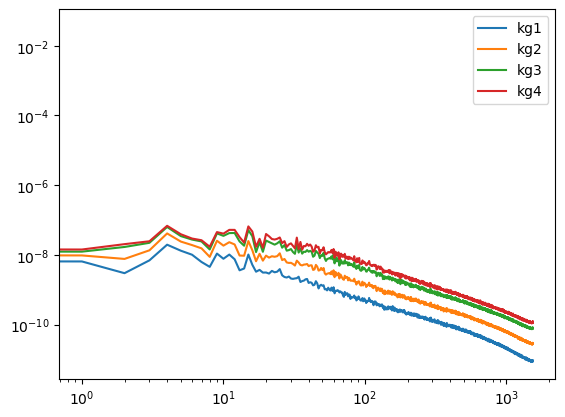

In [77]:
for i in range(4):
    plt.loglog(ells, cls_kg[i], label=f'kg{i+1}')
plt.legend()

### Apply BNT

In [78]:
kg_bnt = M @ kg

In [79]:
cls_kg_bnt = []
cls_kg_bnt_scaled = []
for i in range(4):
    cls_kg_bnt.append(hp.alm2cl(hp.map2alm(kg_bnt[i])))
    ells, cls_kg_bnt_scaled_ = scale_cls(cls_kg_bnt[i])
    cls_kg_bnt_scaled.append(cls_kg_bnt_scaled_)
cls_kg_bnt = np.array(cls_kg_bnt)
cls_kg_bnt_scaled = np.array(cls_kg_bnt_scaled)

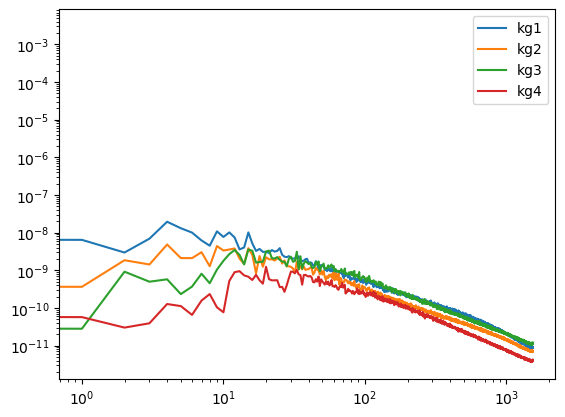

In [80]:
for i in range(4):
    plt.loglog(ells, cls_kg_bnt[i], label=f'kg{i+1}')
plt.legend()

### Compare noBNT and BNT Cls

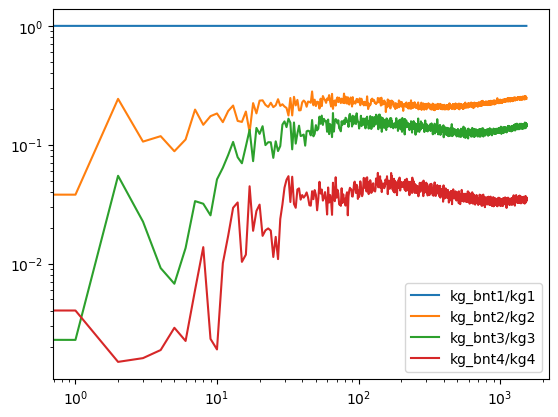

In [81]:
for i in range(4):
    plt.loglog(ells, cls_kg_bnt[i]/cls_kg[i], label=f'kg_bnt{i+1}/kg{i+1}')
plt.legend()

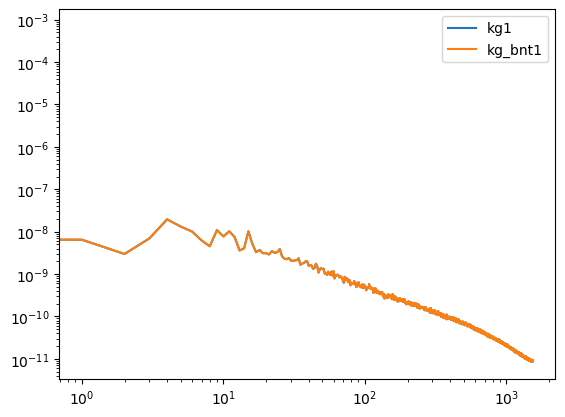

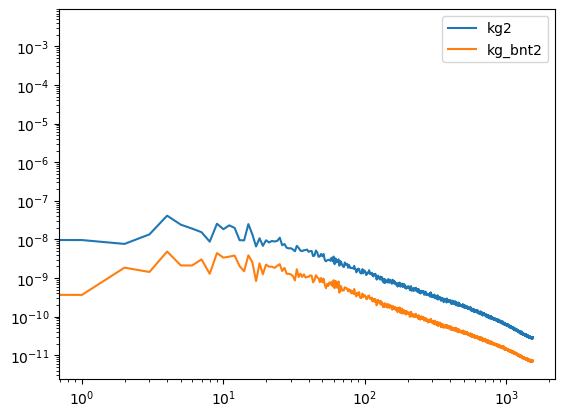

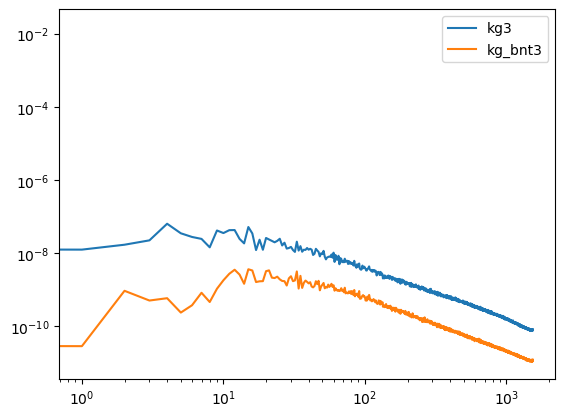

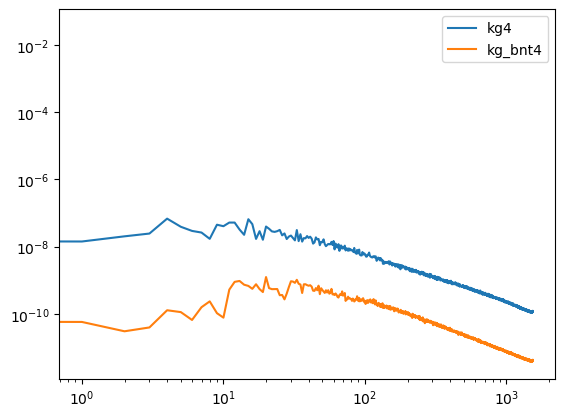

In [82]:
for i in range(4):
    plt.loglog(ells, cls_kg[i], label=f'kg{i+1}')
    plt.loglog(ells, cls_kg_bnt[i], label=f'kg_bnt{i+1}')
    plt.legend()
    plt.show()


## With baryons

In [83]:
kg_b = []
for i in range(4):
    kg_b.append(get_bin_map(i, 0, with_baryons=True, smooth_arcmin=0))
kg_b = np.array(kg_b)

In [84]:
cls_kg_b = []
cls_kg_b_scaled = []
for i in range(4):
    cls_kg_b.append(hp.alm2cl(hp.map2alm(kg_b[i])))
    ells, cls_kg_b_scaled_ = scale_cls(cls_kg_b[i])
    cls_kg_b_scaled.append(cls_kg_b_scaled_)
cls_kg_b = np.array(cls_kg_b)
cls_kg_b_scaled = np.array(cls_kg_b_scaled)

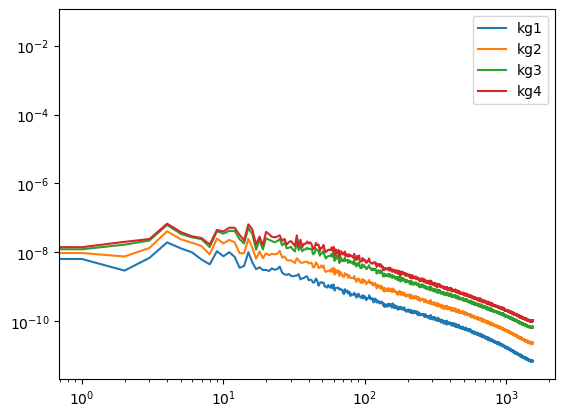

In [85]:
for i in range(4):
    plt.loglog(ells, cls_kg_b[i], label=f'kg{i+1}')
plt.legend()

### Apply BNT

In [86]:
kg_b_bnt = M @ kg_b

In [87]:
cls_kg_b_bnt = []
cls_kg_b_bnt_scaled = []
for i in range(4):
    cls_kg_b_bnt.append(hp.alm2cl(hp.map2alm(kg_b_bnt[i])))
    ells, cls_kg_b_bnt_scaled_ = scale_cls(cls_kg_b_bnt[i])
    cls_kg_b_bnt_scaled.append(cls_kg_b_bnt_scaled_)
cls_kg_b_bnt = np.array(cls_kg_b_bnt)
cls_kg_b_bnt_scaled = np.array(cls_kg_b_bnt_scaled)

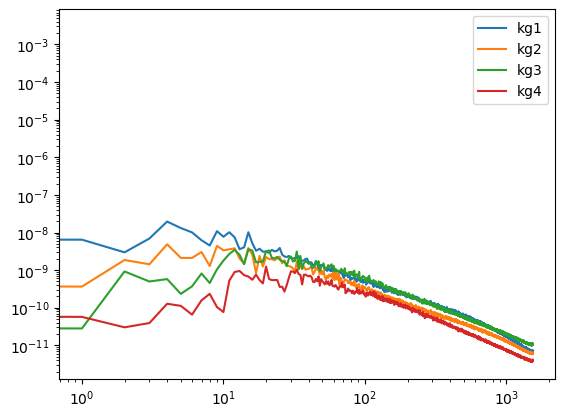

In [88]:
for i in range(4):
    plt.loglog(ells, cls_kg_b_bnt[i], label=f'kg{i+1}')
plt.legend()

### Compare noBNT and BNT Cls

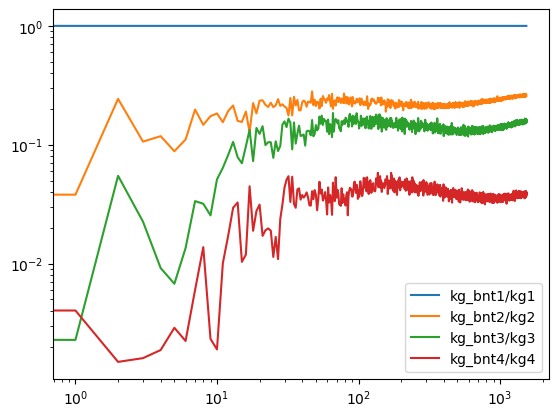

In [89]:
for i in range(4):
    plt.loglog(ells, cls_kg_b_bnt[i]/cls_kg_b[i], label=f'kg_bnt{i+1}/kg{i+1}')
plt.legend()

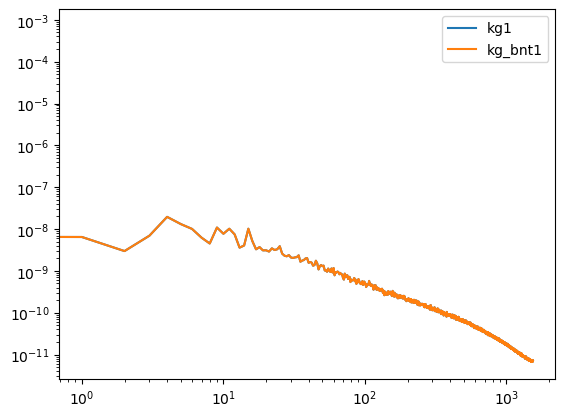

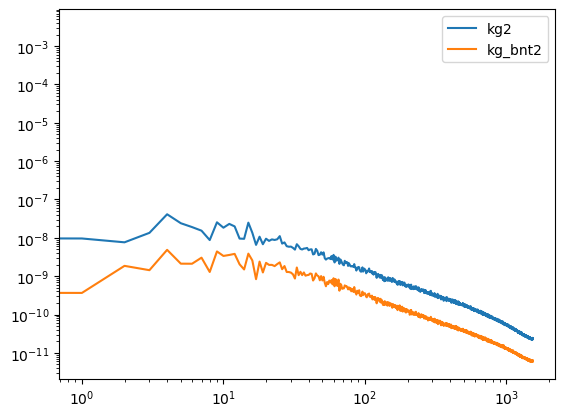

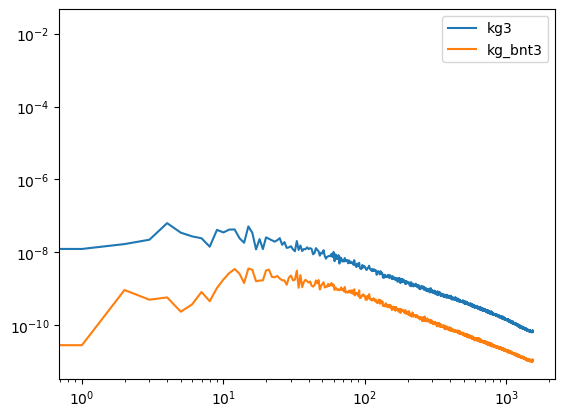

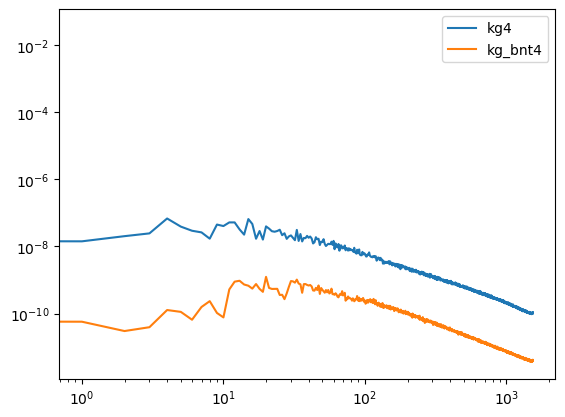

In [90]:
for i in range(4):
    plt.loglog(ells, cls_kg_b[i], label=f'kg{i+1}')
    plt.loglog(ells, cls_kg_b_bnt[i], label=f'kg_bnt{i+1}')
    plt.legend()
    plt.show()
    

## Baryon vs noBaryon comparison

### noBNT

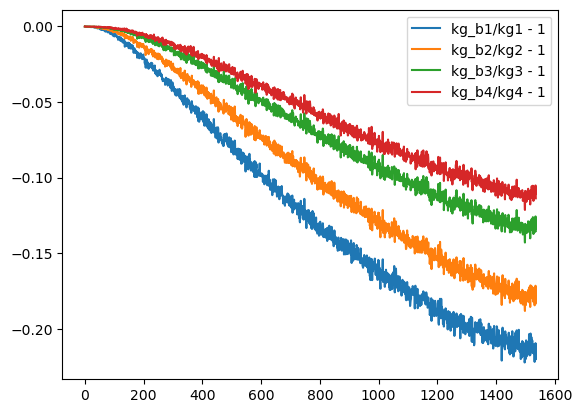

In [91]:
# plot fractional difference
for i in range(4):
    plt.plot(ells, cls_kg_b[i]/cls_kg[i] - 1, label=f'kg_b{i+1}/kg{i+1} - 1')
plt.legend()
plt.show()

### BNT

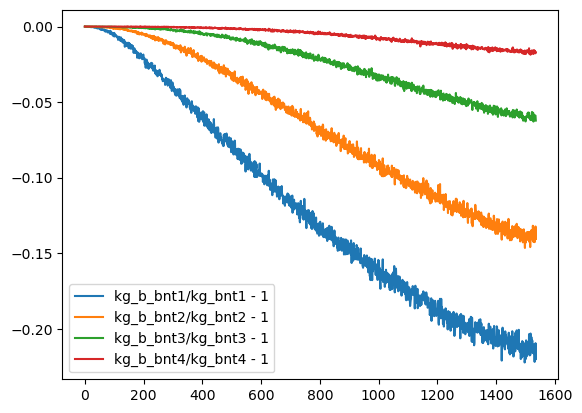

In [92]:
for i in range(4):
    plt.plot(ells, cls_kg_b_bnt[i]/cls_kg_bnt[i] - 1, label=f'kg_b_bnt{i+1}/kg_bnt{i+1} - 1')
plt.legend()
plt.show()

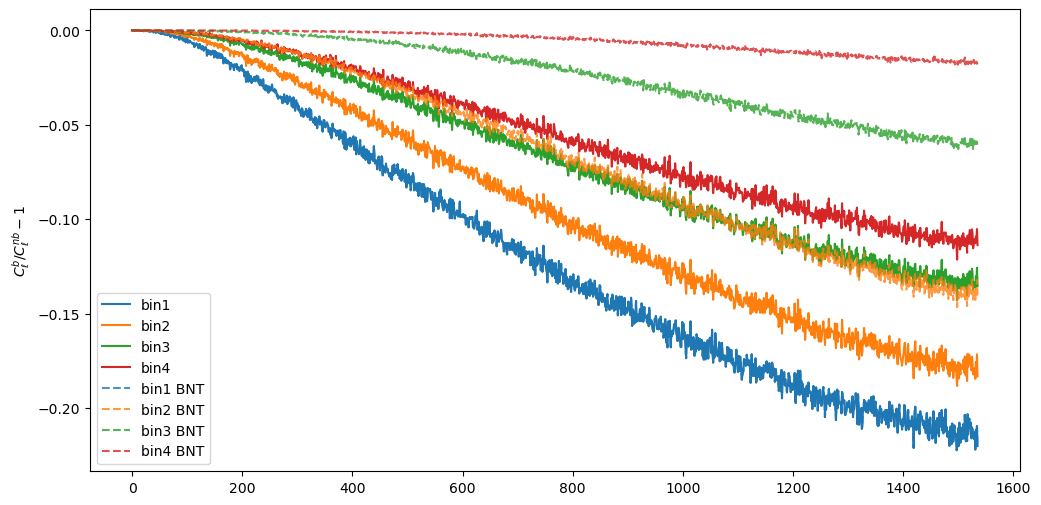

In [120]:
# COMPARISON OF noBNT and BNT FRACTIONAL DIFFERENCES
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(ells, cls_kg_b[i]/cls_kg[i] - 1, label=f'bin{i+1}',
             color=f'C{i}', alpha=1)
for i in range(4):
    plt.plot(ells, cls_kg_b_bnt[i]/cls_kg_bnt[i] - 1, label=f'bin{i+1} BNT',
             color=f'C{i}', alpha=0.8, linestyle='--')
plt.ylabel(r'$C_{\ell}^{b}/C_{\ell}^{nb} - 1$')
plt.legend()

# **$\ell_1$-norm**

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys  

import pycs
from pycs.misc.cosmostat_init import *
from pycs.misc.mr_prog import *
from pycs.misc.im1d_tend import *
from pycs.misc.utilHSS import *
from pycs.misc.stats import *
from pycs.sparsity.mrs.mrs_tools import *

from sys import getsizeof


In [14]:
def get_norm_wtl1_sphere(Map, nscales, nbins=None, Mask=None, min_snr=None, max_snr=None):

    # Set default for nbins if not provided
    if nbins is None:
        nbins = 40

    # Perform undecimated wavelet transform on the spherical map
    WT = mrs_uwttrans(Map, verbose=False)
    energy_per_scale = [np.sum(WT[i]**2) for i in range(nscales)]  # Energy per scale

    # Initialize lists to collect the l1 norm and bins
    l1norm_coll = []
    bins_coll = []

      # Loop through each scale of the wavelet transform
    for i in range(nscales):
        ScaleCoeffs = WT[i]  # Accessing the coefficients for the i-th scale

        # Apply the mask if provided
        if Mask is not None:
            ind = np.where(Mask == 0)
            ScaleCoeffs = ScaleCoeffs[ind]

        # Normalize the wavelet scale to the same energy level
        energy = np.sum(ScaleCoeffs**2)
        normalization_factor = np.sqrt(energy)
        ScaleCoeffs_normalized = ScaleCoeffs / normalization_factor  

        # Set the minimum and maximum values based on inputs or defaults
        min_val = min_snr if min_snr is not None else np.min(ScaleCoeffs_normalized)
        max_val = max_snr if max_snr is not None else np.max(ScaleCoeffs_normalized)

        # Define thresholds and bins
        thresholds = np.linspace(min_val, max_val, nbins + 1)
        bins = 0.5 * (thresholds[:-1] + thresholds[1:])

        # Digitize the values into bins
        digitized = np.digitize(ScaleCoeffs_normalized, thresholds)

        # Calculate the l1 norm for each bin
        bin_l1_norm = [
            np.sum(np.abs(ScaleCoeffs_normalized[digitized == j]))
            for j in range(1, len(thresholds))
        ]

        # Store the bins and l1 norms for this scale
        bins_coll.append(bins)
        l1norm_coll.append(bin_l1_norm)

    # Return the bins and l1 norms for each scale
    return np.array(bins_coll), np.array(l1norm_coll)

## No baryons

In [15]:
bins = []
l1norm = []
for i in range(4):
    bins_, l1norm_ = get_norm_wtl1_sphere(kg[i], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
    bins.append(bins_)
    l1norm.append(l1norm_)
bins = np.array(bins)
l1norm = np.array(l1norm)

setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]


In [44]:
# for i in range(4):
#     for j in range(7):
#         plt.plot(bins[i][j], l1norm[i][j], label=f'kg{i+1} scale {j}')
#         plt.legend()
#     plt.show()

In [29]:
# for j in range(7):
#     for i in range(4):
#         plt.plot(bins[i][j], l1norm[i][j], label=f'kg{i+1} scale {j}')
#         plt.legend()
#     plt.show()

### Apply BNT

In [16]:
bins_bnt = []
l1norm_bnt = []
for i in range(4):
    bins_, l1norm_ = get_norm_wtl1_sphere(kg_bnt[i], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
    bins_bnt.append(bins_)
    l1norm_bnt.append(l1norm_)
bins_bnt = np.array(bins_bnt)
l1norm_bnt = np.array(l1norm_bnt)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [39]:
# for i in range(4):
#     for j in range(7):
#         plt.plot(bins_bnt[i][j], l1norm_bnt[i][j], label=f'kg_bnt{i+1} scale {j}')
#         plt.legend()
#     plt.show()

### Compare noBNT and BNT l1-norms

In [43]:
# for j in range(7):
#     for i in range(4):
#         plt.plot(bins_bnt[i][j], l1norm_bnt[i][j]/l1norm[i][j] - 1, label=f'kg_bnt{i+1} scale {j}')
#         plt.legend()    
#     plt.show()

## With baryons

In [17]:
bins_b = []
l1norm_b = []
for i in range(4):
    bins_, l1norm_ = get_norm_wtl1_sphere(kg_b[i], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
    bins_b.append(bins_)
    l1norm_b.append(l1norm_)
bins_b = np.array(bins_b)
l1norm_b = np.array(l1norm_b)

setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]


In [ ]:
# for i in range(4):
#     for j in range(7):
#         plt.plot(bins_b[i][j], l1norm_b[i][j], label=f'kg{i+1} scale {j}')
#         plt.legend()
#     plt.show()

### Apply BNT

In [18]:
bins_b_bnt = []
l1norm_b_bnt = []
for i in range(4):
    bins_, l1norm_ = get_norm_wtl1_sphere(kg_b_bnt[i], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
    bins_b_bnt.append(bins_)
    l1norm_b_bnt.append(l1norm_)
bins_b_bnt = np.array(bins_b_bnt)
l1norm_b_bnt = np.array(l1norm_b_bnt)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [53]:
# for i in range(4):
#     for j in range(7):
#         plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j], label=f'kg_bnt{i+1} scale {j}')
#         plt.legend()
#     plt.show()

### Compare noBNT and BNT l1-norms

In [55]:
# for j in range(7):
#     for i in range(4):
#         plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j]/l1norm_b[i][j] - 1, label=f'kg_bnt{i+1} scale {j}')
#         plt.legend()
#     plt.show()


## Baryon vs noBaryon comparison

### noBNT

/tmp/ipykernel_670228/2970661853.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins_b[i][j], l1norm_b[i][j]/l1norm[i][j] - 1, label=f'(kg_b{i+1}/kg{i+1} - 1) scale {j}')


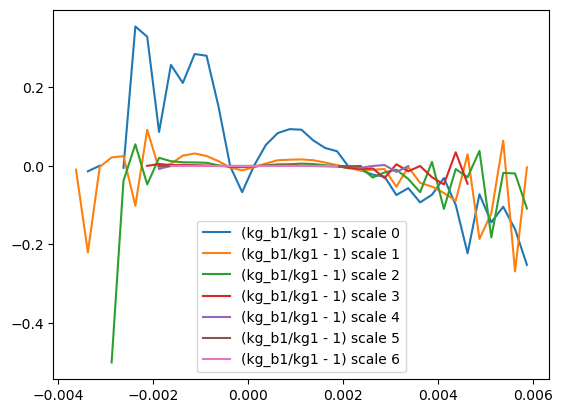

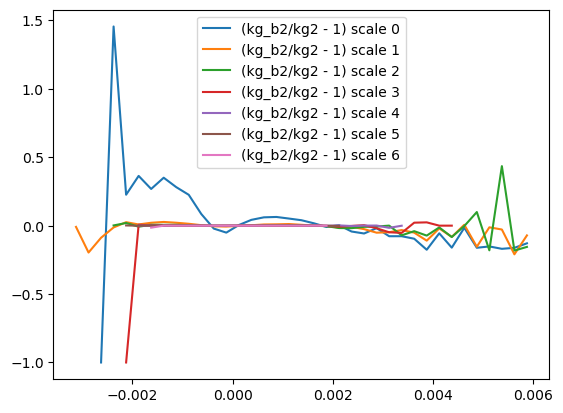

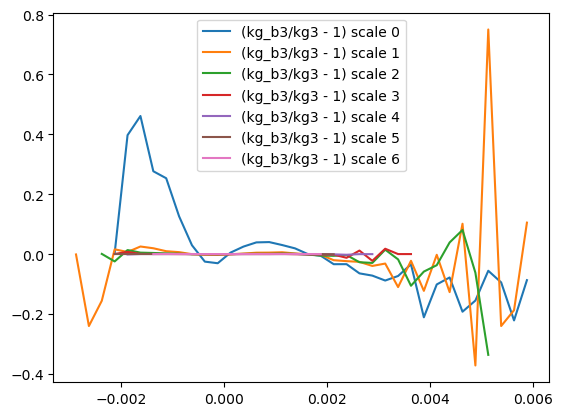

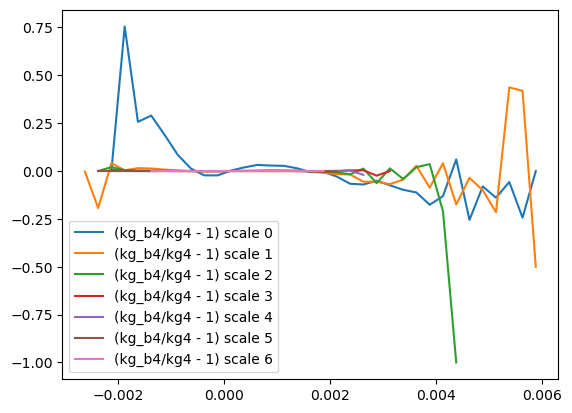

In [21]:
# plot fractional difference
for i in range(4):
    for j in range(7):
        plt.plot(bins_b[i][j], l1norm_b[i][j]/l1norm[i][j] - 1, label=f'(kg_b{i+1}/kg{i+1} - 1) scale {j}')
        plt.legend()
    plt.show()


### BNT

/tmp/ipykernel_670228/2596918765.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j]/l1norm_bnt[i][j] - 1, label=f'(kg_b_bnt{i+1}/kg_bnt{i+1} - 1) scale {j}')


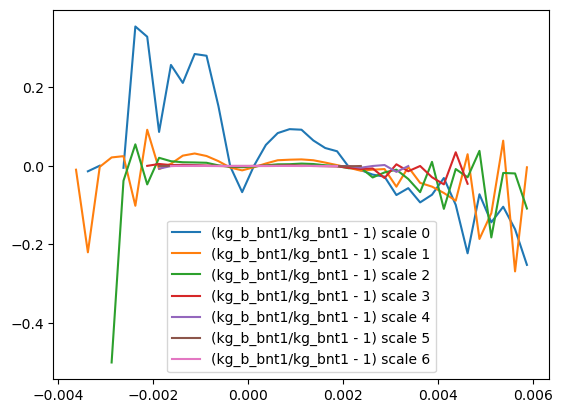

/tmp/ipykernel_670228/2596918765.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j]/l1norm_bnt[i][j] - 1, label=f'(kg_b_bnt{i+1}/kg_bnt{i+1} - 1) scale {j}')


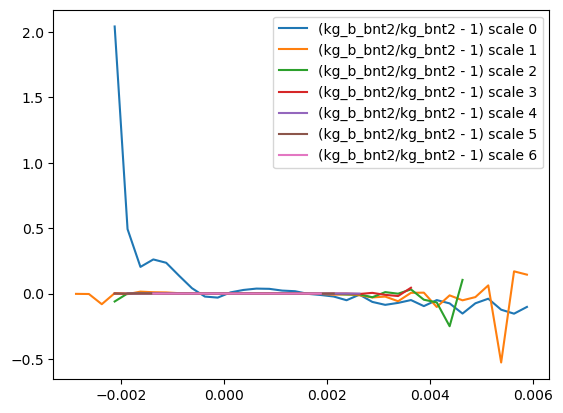

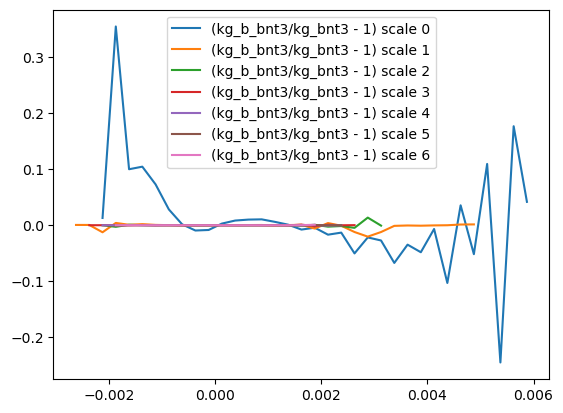

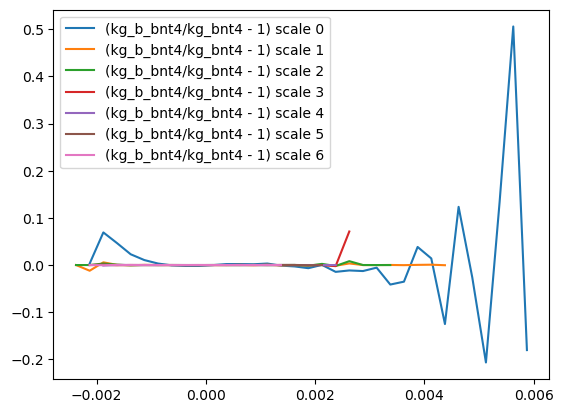

In [28]:
for i in range(4):
    for j in range(7):
        plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j]/l1norm_bnt[i][j] - 1, label=f'(kg_b_bnt{i+1}/kg_bnt{i+1} - 1) scale {j}')
        plt.legend()
    plt.show()

/tmp/ipykernel_670228/2199976480.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins_b[i][j], l1norm_b[i][j]/l1norm[i][j] - 1, label=f'(kg_b{i+1}/kg{i+1} - 1) scale {j}', color='C0')
/tmp/ipykernel_670228/2199976480.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j]/l1norm_bnt[i][j] - 1, label=f'(kg_b_bnt{i+1}/kg_bnt{i+1} - 1) scale {j}', color='C1', alpha=0.7)


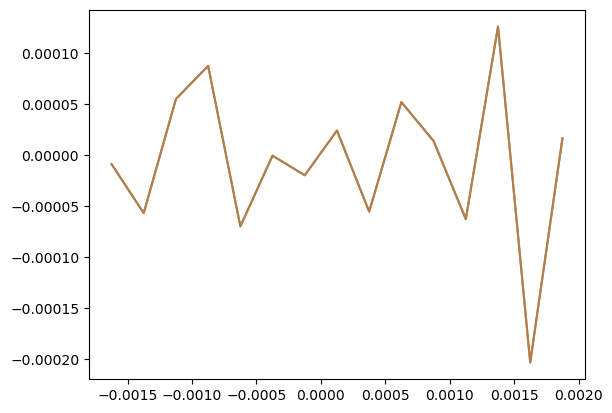

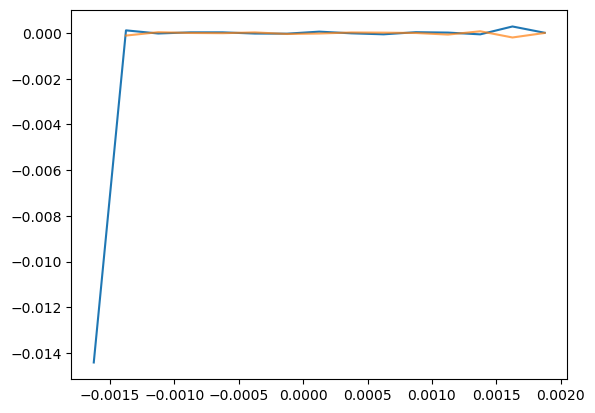

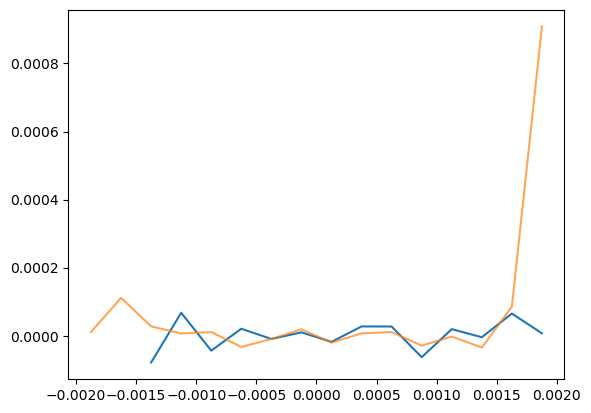

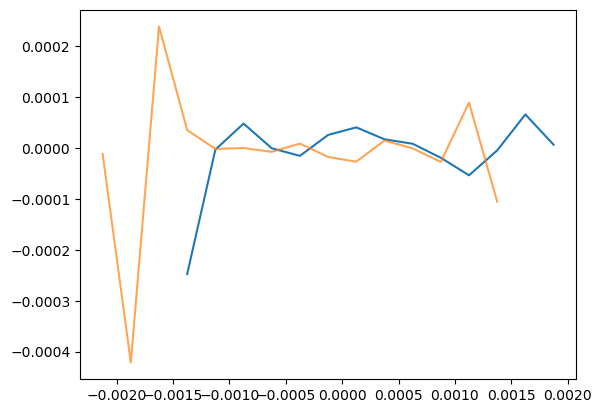

In [37]:
# COMPARISON OF noBNT and BNT FRACTIONAL DIFFERENCES
for i in range(4):
    for j in [6]:
        plt.plot(bins_b[i][j], l1norm_b[i][j]/l1norm[i][j] - 1, label=f'(kg_b{i+1}/kg{i+1} - 1) scale {j}', color='C0')
        plt.plot(bins_b_bnt[i][j], l1norm_b_bnt[i][j]/l1norm_bnt[i][j] - 1, label=f'(kg_b_bnt{i+1}/kg_bnt{i+1} - 1) scale {j}', color='C1', alpha=0.7)
    # plt.legend()
    plt.show()


# Load $\ell_1$-norm arrays for 200 realizations

## noBNT

### No baryons

In [15]:
# Parameters
n_permutations = 200  # Number of permutations (0000 to 0199)
id_zbin = 0  # Redshift bin index, e.g., 0 for the first bin
smooth_arcmin = 0

In [17]:
kg_list = []

for perm_index in range(n_permutations):
    kg = []
    for i in range(4):
        kg.append(get_bin_map(i, perm_index, with_baryons=False, smooth_arcmin=smooth_arcmin))
    kg = np.array(kg)
    kg_list.append(kg)
kg_list = np.array(kg_list)

In [18]:
kg_list.shape

(200, 4, 3145728)

In [26]:
# Calculate the l1 norm for each permutation
l1norm_list = []
for i in range(n_permutations):
    bins = []
    l1norm = []
    for j in range(4):
        bins_, l1norm_ = get_norm_wtl1_sphere(kg_list[i, j], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
        bins.append(bins_)
        l1norm.append(l1norm_)
    bins = np.array(bins)
    l1norm = np.array(l1norm)
    l1norm_list.append(l1norm)
l1norm_list = np.array(l1norm_list)

l1norm_list.shape

setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to

(200, 4, 8, 40)

In [27]:
# # save the l1norm_list
# np.save('l1norm_list_no_baryons_4bins_200perms.npy', l1norm_list)

In [42]:
# load 
l1norm_list = np.load('l1norm_list_no_baryons_4bins_200perms.npy')

In [43]:
# calculate the means over the realizations
l1norm_mean = np.mean(l1norm_list, axis=0)
l1norm_mean.shape

(4, 8, 40)

In [44]:
# calculate the standard deviations over the realizations
l1norm_std = np.std(l1norm_list, axis=0)
l1norm_std.shape

(4, 8, 40)

### With baryons

In [31]:
kg_b_list = []
for perm_index in range(n_permutations):
    kg_b = []
    for i in range(4):
        kg_b.append(get_bin_map(i, perm_index, with_baryons=True, smooth_arcmin=smooth_arcmin))
    kg_b = np.array(kg_b)
    kg_b_list.append(kg_b)
kg_b_list = np.array(kg_b_list)

In [33]:
kg_b_list.shape

(200, 4, 3145728)

In [34]:
# Calculate the l1 norm for each permutation
l1norm_b_list = []
for i in range(n_permutations):
    bins = []
    l1norm = []
    for j in range(4):
        bins_, l1norm_ = get_norm_wtl1_sphere(kg_b_list[i, j], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
        bins.append(bins_)
        l1norm.append(l1norm_)
    bins = np.array(bins)
    l1norm = np.array(l1norm)
    l1norm_b_list.append(l1norm)
l1norm_b_list = np.array(l1norm_b_list)

l1norm_b_list.shape


setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to

(200, 4, 8, 40)

In [35]:
# # save the l1norm_list
# np.save('l1norm_list_baryons_4bins_200perms.npy', l1norm_b_list)

In [45]:
# load
l1norm_b_list = np.load('l1norm_list_baryons_4bins_200perms.npy')

In [46]:
# calculate the means over the realizations
l1norm_b_mean = np.mean(l1norm_b_list, axis=0)
l1norm_b_mean.shape

(4, 8, 40)

In [47]:
# calculate the  standard deviations over the realizations
l1norm_b_std = np.std(l1norm_b_list, axis=0)
l1norm_b_std.shape

(4, 8, 40)

/tmp/ipykernel_1969251/1163852440.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[i][j], (l1norm_b_mean[i][j]-l1norm_mean[i][j])/np.sqrt(l1norm_b_std[i][j]**2 + l1norm_std[i][j]**2) , label=f'scale {j}')


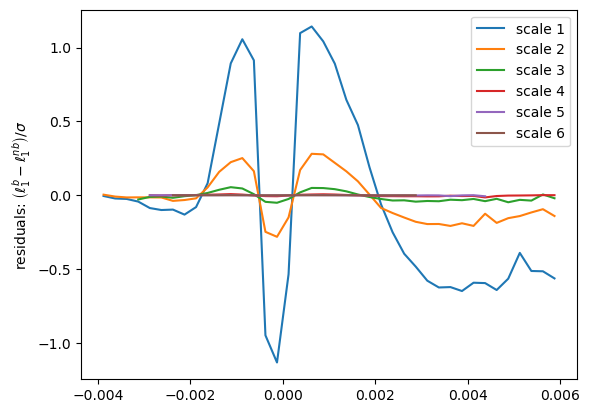

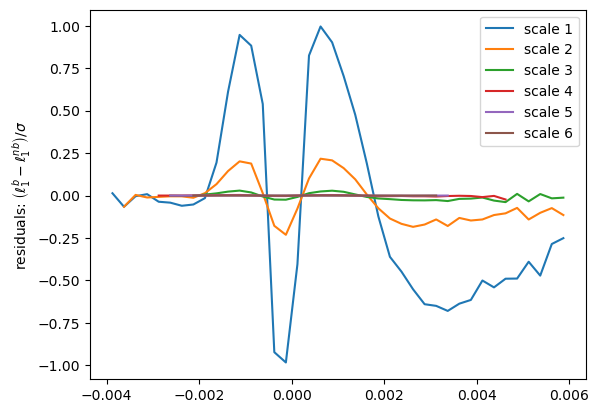

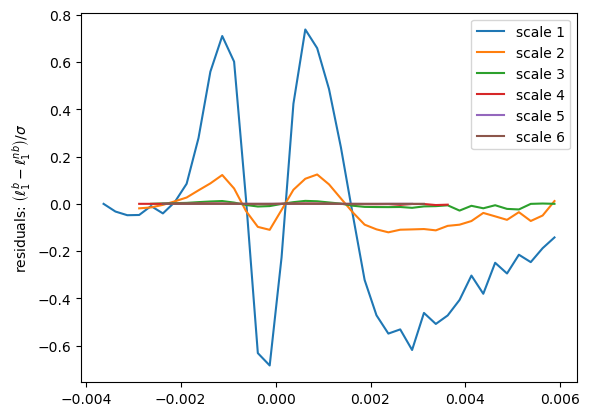

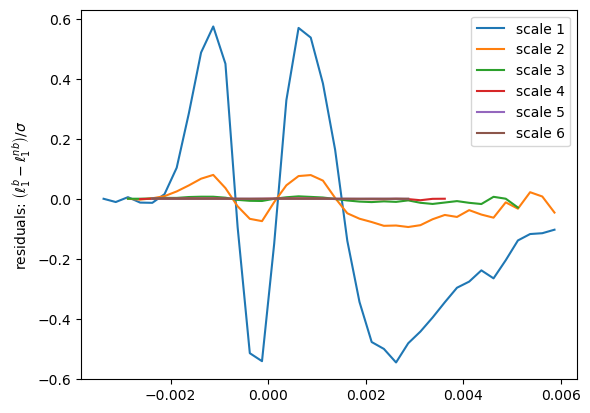

In [64]:
# # plot residuals between no baryons and baryons l1norms
# for i in range(4):
#     for j in [1, 2, 3, 4, 5, 6]:
#         plt.plot(bins[i][j], l1norm_b_mean[i][j]-l1norm_mean[i][j] , label=f'(kg_b{i+1} - kg{i+1}) scale {j}')
#         plt.legend()
#     plt.show()
    
# plot residuals between no baryons and baryons l1norms normalized by the full standard deviation
for i in range(4):
    for j in [1, 2, 3, 4, 5, 6]:
        plt.plot(bins[i][j], (l1norm_b_mean[i][j]-l1norm_mean[i][j])/np.sqrt(l1norm_b_std[i][j]**2 + l1norm_std[i][j]**2) , label=f'scale {j}')
        plt.legend()
        plt.ylabel('residuals: $ \\left( \ell_1^{b} - \ell_1^{nb} \\right) /\sigma$')
    plt.show()


## BNT

### No baryons

In [20]:
kg_list.shape

(200, 4, 3145728)

In [21]:
# create the kg_bnt_list by applying the M matrix to each group of 4 redshift bins
kg_bnt_list = []
for i in range(n_permutations):
    kg_bnt = M @ kg_list[i]
    kg_bnt_list.append(kg_bnt)
kg_bnt_list = np.array(kg_bnt_list)

In [22]:
kg_bnt_list.shape

(200, 4, 3145728)

In [24]:
# calculate the l1 norm for each permutation
l1norm_bnt_list = []
for i in range(n_permutations):
    bins = []
    l1norm = []
    for j in range(4):
        bins_, l1norm_ = get_norm_wtl1_sphere(kg_bnt_list[i, j], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
        bins.append(bins_)
        l1norm.append(l1norm_)
    bins = np.array(bins)
    l1norm = np.array(l1norm)
    l1norm_bnt_list.append(l1norm)
l1norm_bnt_list = np.array(l1norm_bnt_list)


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to

In [25]:
l1norm_bnt_list.shape

(200, 4, 8, 40)

In [26]:
# save the l1norm_list
np.save('l1norm_list_bnt_no_baryons_4bins_200perms.npy', l1norm_bnt_list)

In [27]:
# calculate the means over the realizations
l1norm_bnt_mean = np.mean(l1norm_bnt_list, axis=0)
l1norm_bnt_mean.shape

(4, 8, 40)

In [28]:
# calculate the standard deviations over the realizations
l1norm_bnt_std = np.std(l1norm_bnt_list, axis=0)
l1norm_bnt_std.shape

(4, 8, 40)

### With baryons

In [32]:
kg_b_list.shape

(200, 4, 3145728)

In [33]:
# create the kg_b_bnt_list by applying the M matrix to each group of 4 redshift bins
kg_b_bnt_list = []
for i in range(n_permutations):
    kg_b_bnt = M @ kg_b_list[i]
    kg_b_bnt_list.append(kg_b_bnt)
kg_b_bnt_list = np.array(kg_b_bnt_list)

kg_b_bnt_list.shape

(200, 4, 3145728)

In [34]:
# calculate the l1 norm for each permutation
l1norm_b_bnt_list = []
for i in range(n_permutations):
    bins = []
    l1norm = []
    for j in range(4):
        bins_, l1norm_ = get_norm_wtl1_sphere(kg_b_bnt_list[i, j], nscales=8, nbins=None, Mask=None, min_snr=-0.004, max_snr=0.006)
        bins.append(bins_)
        l1norm.append(l1norm_)
    bins = np.array(bins)
    l1norm = np.array(l1norm)
    l1norm_b_bnt_list.append(l1norm)
l1norm_b_bnt_list = np.array(l1norm_b_bnt_list)

l1norm_b_bnt_list.shape


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to

(200, 4, 8, 40)

In [35]:
# save the l1norm_list
np.save('l1norm_list_bnt_baryons_4bins_200perms.npy', l1norm_b_bnt_list)

In [36]:
# calculate the means over the realizations
l1norm_b_bnt_mean = np.mean(l1norm_b_bnt_list, axis=0)
l1norm_b_bnt_mean.shape

(4, 8, 40)

In [37]:
# calculate the standard deviations over the realizations
l1norm_b_bnt_std = np.std(l1norm_b_bnt_list, axis=0)
l1norm_b_bnt_std.shape

(4, 8, 40)

/tmp/ipykernel_1969251/3460636680.py:12: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[i][j], (l1norm_b_bnt_mean[i][j]-l1norm_bnt_mean[i][j])/np.sqrt(l1norm_b_bnt_std[i][j]**2 + l1norm_bnt_std[i][j]**2) , label=f'scale {j}')


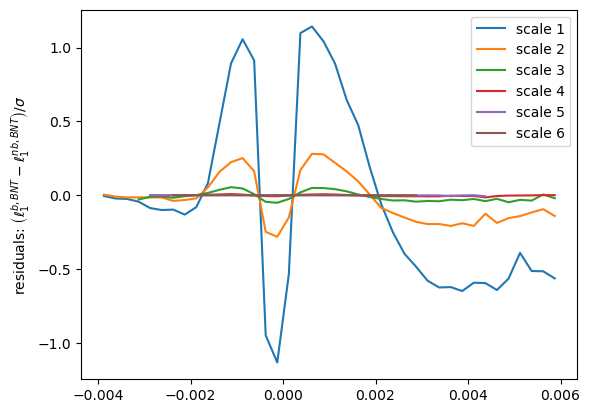

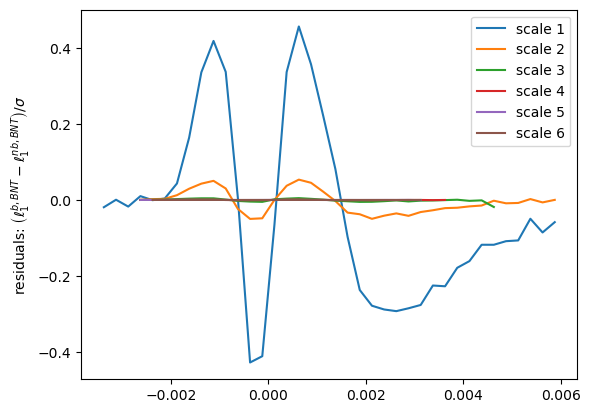

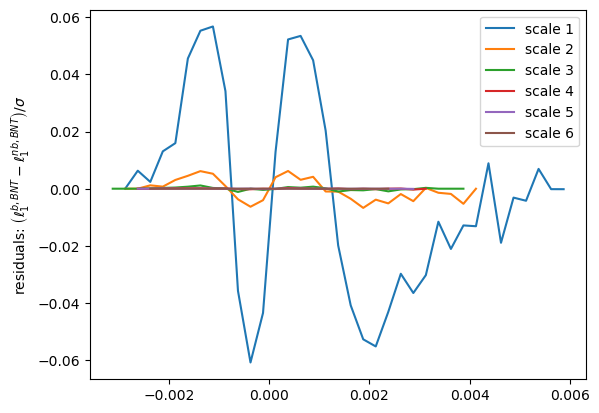

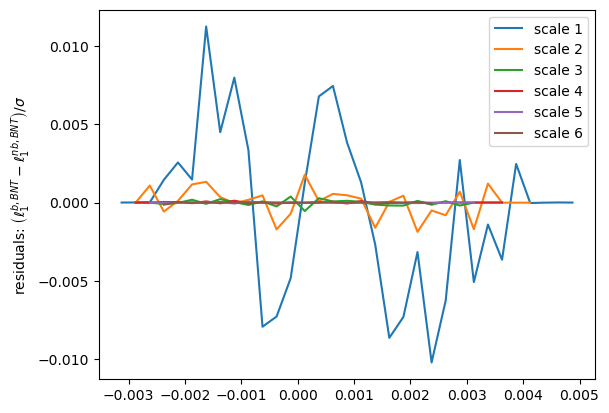

In [66]:
# # plot residuals between no baryons and baryons l1norms
# for i in range(4):
#     for j in [1, 2, 3, 4, 5, 6]:
#         plt.plot(bins[i][j], l1norm_b_bnt_mean[i][j]-l1norm_bnt_mean[i][j] , label=f'(kg_b_bnt{i+2} - kg_bnt{i+2}) scale {j}')
#         plt.legend()
#     plt.show()

    
# plot residuals between no baryons and baryons l1norms normalized by the full standard deviation
for i in range(4):
    for j in [1, 2, 3, 4, 5, 6]:
        plt.plot(bins[i][j], (l1norm_b_bnt_mean[i][j]-l1norm_bnt_mean[i][j])/np.sqrt(l1norm_b_bnt_std[i][j]**2 + l1norm_bnt_std[i][j]**2) , label=f'scale {j}')
        plt.legend()
        plt.ylabel('residuals: $ \\left( \ell_1^{b, BNT} - \ell_1^{nb, BNT} \\right) /\sigma$')
    plt.show()

## BNT vs noBNT comparison

/tmp/ipykernel_1969251/237065797.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[i][j], (l1norm_b_bnt_mean[i][j]-l1norm_bnt_mean[i][j])/np.sqrt(l1norm_b_bnt_std[i][j]**2 + l1norm_bnt_std[i][j]**2) , label=f'BNT bin {i+1}', color=f'C{i}')
/tmp/ipykernel_1969251/237065797.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[i][j], (l1norm_b_mean[i][j]-l1norm_mean[i][j])/np.sqrt(l1norm_b_std[i][j]**2 + l1norm_std[i][j]**2) , label=f'no BNT bin {i+1}', ls='--', color=f'C{i}')


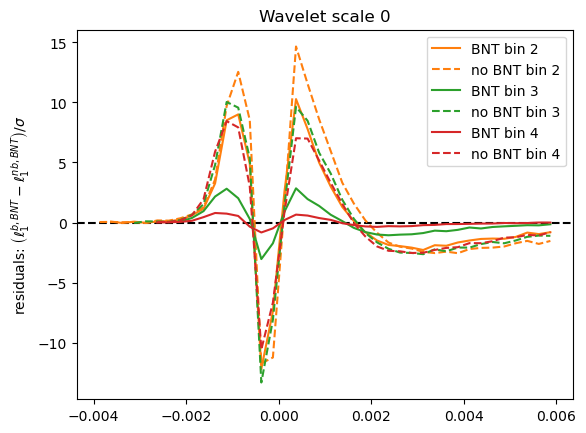

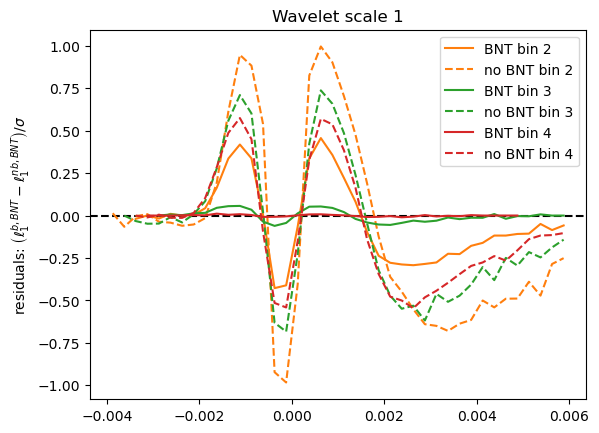

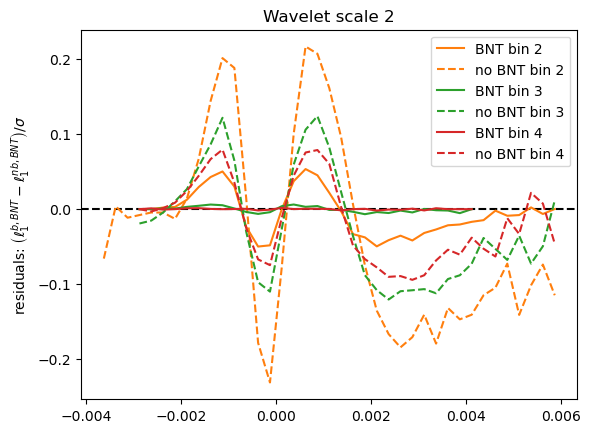

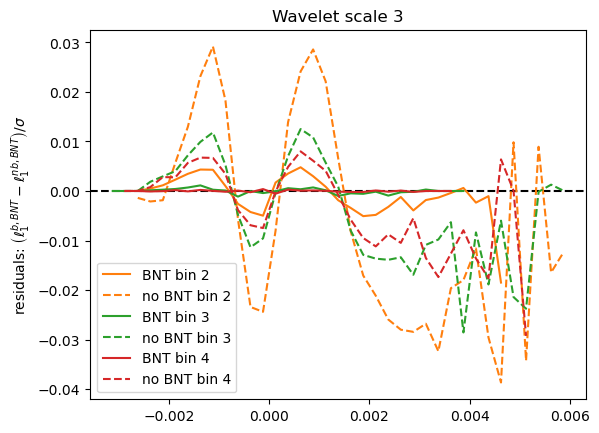

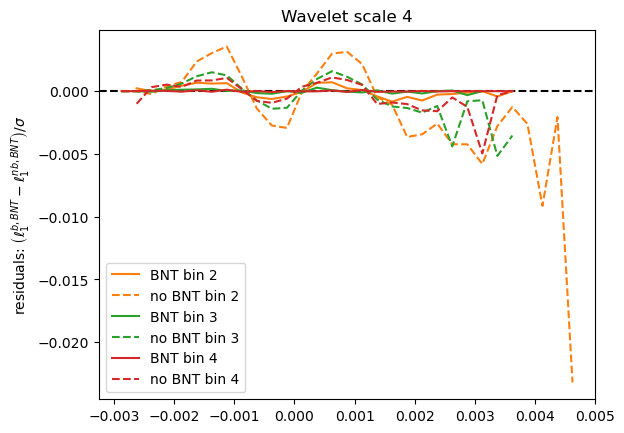

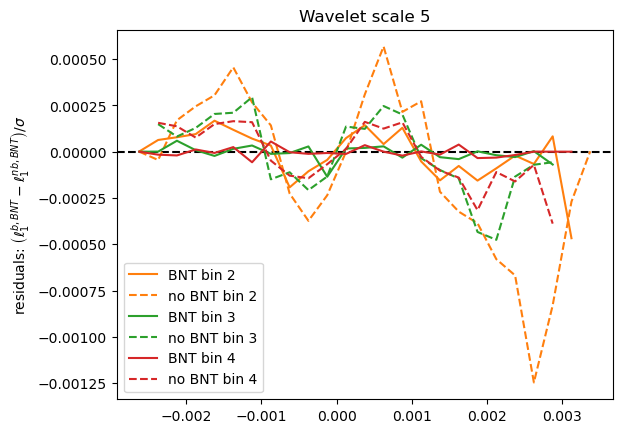

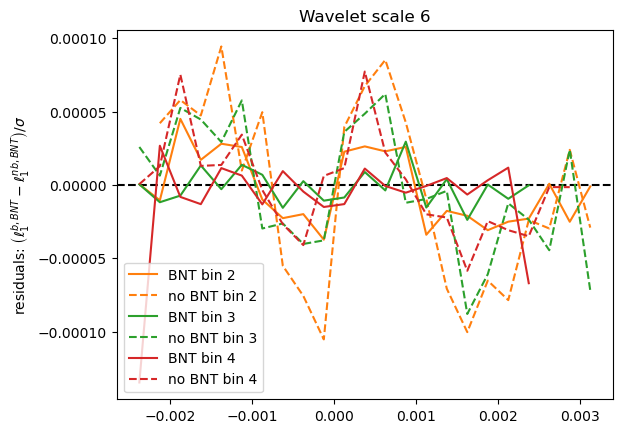

In [74]:
# plot residuals for 1st scale for all redshift bins, for BNT and no BNT
for j in range(7):
    plt.axhline(0, color='black', ls='--')
    for i in [1,2,3]:
        plt.plot(bins[i][j], (l1norm_b_bnt_mean[i][j]-l1norm_bnt_mean[i][j])/np.sqrt(l1norm_b_bnt_std[i][j]**2 + l1norm_bnt_std[i][j]**2) , label=f'BNT bin {i+1}', color=f'C{i}')
        plt.plot(bins[i][j], (l1norm_b_mean[i][j]-l1norm_mean[i][j])/np.sqrt(l1norm_b_std[i][j]**2 + l1norm_std[i][j]**2) , label=f'no BNT bin {i+1}', ls='--', color=f'C{i}')
        plt.legend()
        plt.ylabel('residuals: $ \\left( \ell_1^{b, BNT} - \ell_1^{nb, BNT} \\right) /\sigma$')
        plt.title(f'Wavelet scale {j}')
    plt.show()
